In [22]:
import pandas as pd
import numpy as np
df = pd.read_csv('data\SPFB.RTS_090601_190813.txt',sep=',')
df['Timestamp'] = df["<DATE>"].astype(str) + df["<TIME>"].astype(str)
df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='%Y%m%d%H%M%S')
df.set_index('Timestamp',inplace=True)
df.drop(['<DATE>','<TIME>'],axis=1,inplace=True)
df.columns = ['Open','High','Low','Close','Vol']
df.drop('Vol',axis=1,inplace=True)
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [23]:
conversion = {'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last'}
df=df.resample('30Min', how=conversion)
df.dropna(inplace=True)

C:\ProgramData\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


In [24]:
def bar_norm(df):
    t2=df.copy()
    temp=df.copy()
    temp['dif_close_1_cum']=(temp['Close']-temp['Close'].shift()).shift().cumsum()
    t2['Open_std']=t2['Open'] - temp['dif_close_1_cum']
    t2['High_std']=t2['High'] - temp['dif_close_1_cum']
    t2['Low_std']=t2['Low'] - temp['dif_close_1_cum']
    t2['Close_std']=t2['Close'] - temp['dif_close_1_cum']
    t2['Open_std']=t2['Open_std'] - temp['Close'][0]
    t2['High_std']=t2['High_std'] - temp['Close'][0]
    t2['Low_std']=t2['Low_std'] - temp['Close'][0]
    t2['Close_std']=t2['Close_std'] - temp['Close'][0]
    t2=t2.iloc[2:]
    return t2

def bar_norm_all(df):
    df=bar_norm(df)
    df['std']=df['Close_std'].rolling(1250).std()
    df.dropna(inplace=True)
    df['Open_std']=df['Open_std']/df['std']
    df['High_std']=df['High_std']/df['std']
    df['Low_std']=df['Low_std']/df['std']
    df['Close_std']=df['Close_std']/df['std']
    df.drop('std',axis=1,inplace=True)
    return df
df=bar_norm_all(df)
df=df[-70000:]
df_train=df[:-30000]
df_valid=df[-30000:-15000]
df_test=df[-15000:]

In [25]:
import gym
import gym_RTStrade

In [26]:
env = gym.make('Trade-v1')
env.data_init(df_train,df_valid,df_test,df_test.iloc[:,:4])

v1.2


In [27]:
def score_train_model(model):   
    obs = env.reset_to_trainScore()
    obs_v=obs.values
    while True:      
        state = np.reshape(obs_v, [1, 40, 4])
        predict = model.predict([state])[0]
        action = np.argmax(predict)
        obs, reward, done, _ = env.step(action)
        obs_v=obs.values
        if done:
            print('done')
            break
    
    return (env.net,env.action_count)

def score_valid_model(model):
    obs = env.reset_to_validScore()
    obs_v=obs.values
    while True:       
        state = np.reshape(obs_v, [1, 40, 4])
        predict = model.predict([state])[0]
        action = np.argmax(predict)
        obs, reward, done, _ = env.step(action)
        obs_v=obs.values
        if done:
            print('done')
            break
    return (env.net,env.action_count)

def score_test_model(model):
    obs = env.reset_to_testScore()
    obs_v=obs.values
    while True:       
        state = np.reshape(obs_v, [1, 40, 4])
        predict = model.predict([state])[0]
        action = np.argmax(predict)
        obs, reward, done, _ = env.step(action)
        obs_v=obs.values
        if done:
            print('done')
            break
    return (env.net,env.action_count)

def score_testReal_model(model):
    obs = env.reset_to_testReal()
    obs = bar_norm_all(obs)
    obs=obs.iloc[-40:,4:]
    obs_v=obs.values
    while True:      
        state = np.reshape(obs_v, [1, 40, 4])
        predict = model.predict([state])[0]
        action = np.argmax(predict)
        obs, reward, done, _ = env.step_real(action)
        obs = bar_norm_all(obs)
        obs=obs.iloc[-40:,4:]
        obs_v=obs.values
        if done:
            print('done')
            break
    return (env.net,env.action_count)

In [29]:
from keras.models import load_model
model_p=load_model('models/model_v1big_199799')


In [30]:
model_p.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         (None, 40, 4)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 16)            208       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 24)            1176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 24)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 32)            2336      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 48)            4656      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 48)             0         
__________

In [42]:
env.action_count

array([8791,    0, 6169])

done


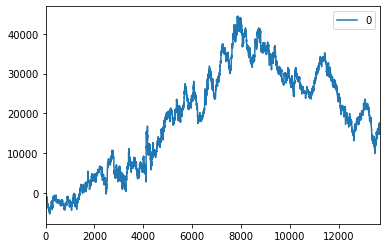

In [43]:
score_testR, tac_testR = score_testReal_model(model_p)
env.action_count
pd.DataFrame(env.returns).cumsum().plot()

done


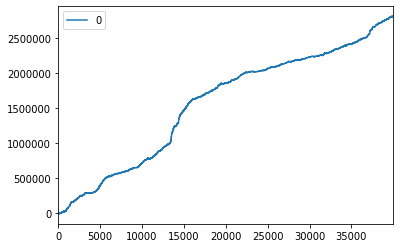

In [44]:
score_test= score_train_model(model_p)
env.action_count
pd.DataFrame(env.returns).cumsum().plot()

done


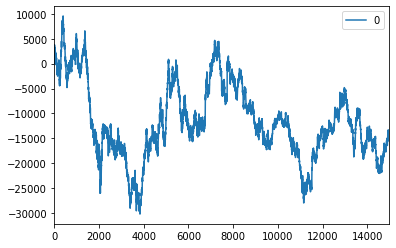

In [45]:
score_valid, tac_valid= score_valid_model(model_p)
env.action_count
pd.DataFrame(env.returns).cumsum().plot()

done


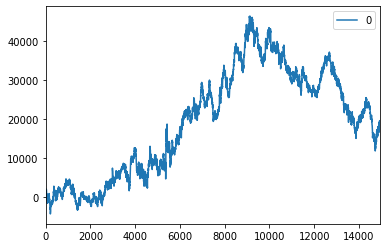

In [46]:
env.action_count
score_test, tac_test = score_test_model(model_p)
pd.DataFrame(env.returns).cumsum().plot()

array([8791,    0, 6169])

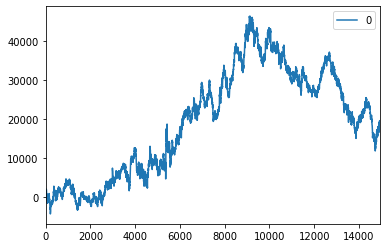

In [41]:
#pd.DataFrame(env.returns).cumsum().plot()